In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%cd ..

/jupyter-lab/repo/bigstar


# Import Modules

In [150]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pickle
from collections import Counter
from functools import partial

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from src.base_trainer import get_ckpt_path, get_model_hparams, load_model_state
from src.baseline.models import BaselineModel, BaselineModelWithMLAttention
from src.baseline.trainer import BaselineTrainerModel
from src.datasets import LotteQADataset, collate_fn
from src.eda import EDA
from src.utils import filter_arguments, get_label_encoder
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import AutoConfig, AutoTokenizer

# EDA

## # of Samples

In [30]:
train_df1 = pd.read_csv("data/train01.csv")
train_df1 = train_df1[train_df1["QA여부"] == "q"]

train_df2 = pd.read_csv("data/train02.csv")
train_df2 = train_df2[train_df2["QA여부"] == "q"]

train_df = pd.concat([train_df1, train_df2])

valid_df = pd.read_csv("data/validation.csv")
valid_df = valid_df[valid_df["QA여부"] == "q"]

test_df = pd.read_csv("data/test.csv")
test_df = test_df[test_df["QA여부"] == "q"]

print(f"# of rows (train01): {len(train_df1):,}")
print(f"# of rows (train02): {len(train_df2):,}")
print(f"# of rows (validation): {len(valid_df):,}")
print(f"# of rows (test): {len(test_df):,}")

train_df1.head()

# of rows (train01): 441,874
# of rows (train02): 273,175
# of rows (validation): 114,288
# of rows (test): 89,878


,IDX,발화자,발화문,카테고리,QA번호,QA여부,감성,인텐트,가격,수량,크기,장소,조직,사람,시간,날짜,상품명,상담번호,상담내순번
0,433813,c,높이 길이를 좀 더 길게 해주실 수 있나요?,가구인테리어,1,q,m,제품_정보,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
2,441787,c,그레이 커튼을 배송받았는데요레이스 커튼이 흰색이 아니고 회색이네요 잘못 온 건가요?,가구인테리어,2,q,m,배송_오류,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,그레이 커튼|레이스 커튼,2,1
4,325930,c,거실 총길이가 가로 480세로 230인데 어떤 걸로 신청해야 하나요?,가구인테리어,4,q,m,제품_정보,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1
6,70824,c,레이스 커튼만 개별 구매 안 될까요?,가구인테리어,5,q,m,구매_제품,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,레이스 커튼,5,1
8,253329,c,화이트 구입 시 봉색이 화이트로 오나요?,가구인테리어,6,q,m,제품_구성,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,1


## # of Samples per Label

In [83]:
value_counts = pd.DataFrame(train_df['인텐트'].value_counts())
value_counts

,인텐트
배송_날짜,153516
제품_정보,124759
제품_구성,46528
제품_방법,42915
제품_추천,39719
...,...
주문_변경,132
포장_비용,125
주문_오류,106
주문_추가,103


## Label Distribution

<AxesSubplot:>

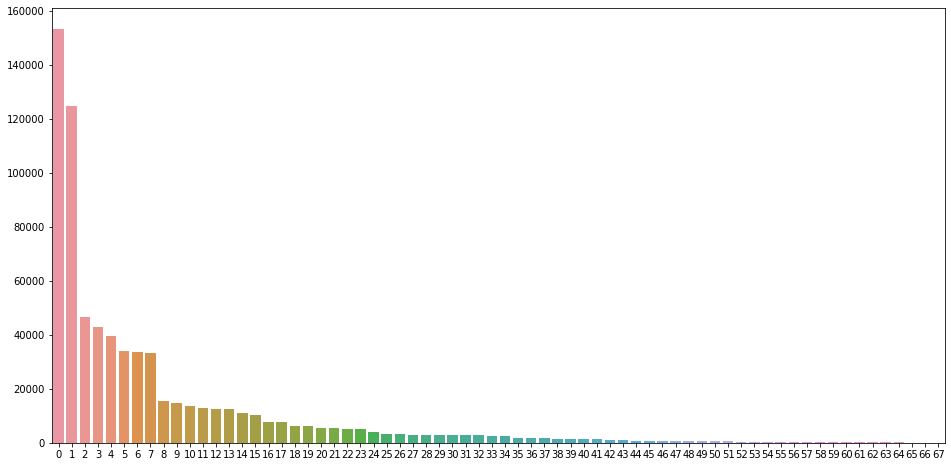

In [82]:
plt.figure(figsize=(16, 8))
sns.barplot(x=np.arange(len(value_counts)), y=value_counts["인텐트"].to_numpy())

## Stat of Input Token

In [124]:
tokenzier = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")
input_lengths = []
for text in tqdm(train_df["발화문"]):
    input_lengths.append(len(tokenzier(text)["input_ids"]))

input_lengths = np.array(input_lengths)
print(f"avg. length of input token: {np.mean(input_lengths):.2f}")
print(f"std. length of input token: {np.std(input_lengths):.2f}")
print(f"median length of input token: {np.median(input_lengths)}")
print(f"min length of input token: {np.min(input_lengths):.2f}")
print(f"max length of input token: {np.max(input_lengths):.2f}")

avg. length of input token: 18.30
std. length of input token: 9.30
median length of input token: 16.0
min length of input token: 4.00
max length of input token: 233.00


# Dataset

In [161]:
dataset = LotteQADataset()
le = LabelEncoder().fit(dataset.y)
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

In [162]:
dataloader = DataLoader(
    dataset,
    batch_size=16,
    collate_fn=partial(collate_fn, tokenizer=tokenizer, le=le, max_length=30),
)

In [163]:
batch = next(iter(dataloader))

# Model

In [198]:
model = BaselineModel(
    num_labels=len(le.classes_),
    pretrained_model_name="monologg/koelectra-base-v3-discriminator",
    use_layernorm=True,
)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [199]:
with torch.no_grad():
    outputs = model(batch[0])

# Test

In [204]:
run_id = "d81d4ec7c72a49ca923a660103a9f631"
ckpt_path = get_ckpt_path(log_dir="./logs", run_id=run_id, load_best=True)
model_hparams = get_model_hparams("./logs", run_id, BaselineTrainerModel.MODEL_HPARAMS)
le = get_label_encoder("./cache/label_encoder")

model_cls = (
    BaselineModel
    if model_hparams["model_name"] == "Baseline"
    else BaselineModelWithMLAttention
)

model = model_cls(
    num_labels=len(le.classes_), **filter_arguments(model_hparams, model_cls)
)

load_model_state(model, ckpt_path, substitution=(r"^model\.", ""))

test_dataset = LotteQADataset(mode="test")
tokenizer = AutoTokenizer.from_pretrained(model_hparams["pretrained_model_name"])
test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    pin_memory=True,
    num_workers=4,
    collate_fn=partial(
        collate_fn, tokenizer=tokenizer, le=le, max_length=model_hparams["max_length"]
    ),
)

device = torch.device("cuda")

model.to(device)
model.eval()
predictions = []

for batch_x, batch_y in tqdm(test_dataloader):
    batch_x = {k: v.to(device) for k, v in batch_x.items()}
    with torch.no_grad(), torch.cuda.amp.autocast():
        outputs = model(batch_x)
    predictions.append(outputs.argmax(dim=-1).cpu())

predictions = np.concatenate(predictions)

gt = le.transform(test_dataset.y)
f1_micro = f1_score(gt, predictions, average="micro")
f1_macro = f1_score(gt, predictions, average="macro")
f1 = f1_score(gt, predictions, average=None)

print(f"f1 (micro): {f1_micro:.4f}")
print(f"f1 (macro): {f1_macro:.4f}")

matrix = confusion_matrix(gt, predictions)

data = {
    "intent": le.classes_,
    "f1": f1,
    "support": matrix.sum(axis=-1),
    "# to tp": np.diag(matrix),
    "# of predicted": matrix.sum(axis=0),
}

df = pd.DataFrame(data)
df.to_excel("outputs/predictions.xlsx", index=False)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/2809 [00:00<?, ?it/s]

f1 (micro): 0.5271
f1 (macro): 0.0723


## Analysis Predictions

In [180]:
label_idx = le.transform(["제품_일반"])[0]
predicted_label_idx = np.where(matrix[:, label_idx] != 0)[0]
predicted_label_idx = predicted_label_idx[np.where(predicted_label_idx != label_idx)[0]]
predicted = matrix[:, label_idx][predicted_label_idx]

df = pd.DataFrame(
    {"intent": le.classes_[predicted_label_idx], "# of predicted": predicted}
)
df.sort_values(by="# of predicted", ascending=False)

,intent,# of predicted
20,제품_정보,95
19,제품_재고,54
14,제품_방법,41
13,제품_구성,32
1,결제_일반,24
11,웹사이트_사용,14
9,배송_일반,9
22,제품_커스텀,7
18,제품_입고,7
21,제품_추천,5


In [196]:
train_dataset = LotteQADataset(aug_filename="augmented.eda.v2.csv")
counter = Counter(le.transform(train_dataset.y))
label, cnt = zip(*counter.items())
label = np.array(label)
cnt = np.array(cnt)
idx = np.argsort(label)

data = {"intent": le.classes_, "# of samples": cnt[idx]}
df = pd.DataFrame(data)
df.to_excel("outputs/cnt.xlsx", index=False)

# Easy Data Augmentation

In [88]:
train_dataset = LotteQADataset()

In [193]:
eda = EDA(num_aug=3, p_sr=0, p_ri=0, p_rd=0.5, p_rs=0.5)
original = train_dataset[2][0]
augmented = eda(original)

print("Original text:")
print(original)
print()
print("Augmented text:")
print("\n".join(augmented))

Original text:
그레이 커튼이 흰색이 아니고 회색이네요 잘못 건가요?

Augmented text:
그레이 커튼이 잘못 아니고 회색이네요 흰색이 건가요?
그레이 아니고 잘못 건가요?


In [194]:
eda = EDA(num_aug=3, p_sr=0, p_ri=0, p_rd=0.5, p_rs=0.5)
train_dataset = LotteQADataset()
augmented = []
for text, label in tqdm(train_dataset):
    aug = eda(text)
    augmented.extend([(t, label) for t in aug])

  0%|          | 0/715049 [00:00<?, ?it/s]

In [195]:
text, labels = zip(*augmented)
df = pd.DataFrame({"발화문": text, "인텐트": labels})
df.to_csv('data/augmented.eda.v2.csv', index=False)

In [394]:
model.eval()
predictions = []

for batch_x, batch_y in tqdm(test_dataloader):
    batch_x = {k: v.to(device) for k, v in batch_x.items()}
    with torch.no_grad():
        outputs = model(batch_x)
    predictions.append(outputs.argmax(dim=-1).cpu())

predictions = np.concatenate(predictions)

le = get_label_encoder('./cache/label_encoder')
gt = le.transform(test_dataset.y)
f1_micro = f1_score(gt, predictions, average='micro')
f1_macro = f1_score(gt, predictions, average='macro')
f1 = f1_score(gt, predictions, average=None)

print(f"f1 (micro): {f1_micro:.4f}")
print(f"f1 (macro): {f1_macro:.4f}")

  0%|          | 0/28087 [00:01<?, ?it/s]

f1 (micro): 0.7305
f1 (macro): 0.5125


In [396]:
counter = Counter(gt)

label, cnt = zip(*counter.items())
label = np.array(label)
cnt = np.array(cnt)
idx = np.argsort(label)

data = {"intent": le.classes_, "f1": f1, "support": cnt[idx]}
df = pd.DataFrame(data)
df.to_excel("predictions.xlsx", index=False)

# Backtranslation